## Классификация MNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [35]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

Давайте обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В этом задании мы воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплайн обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку с первого занятия.

Мы настоятельно рекомендуем писать код «с нуля», лишь изредка подглядывая в готовые примеры, а не просто «копировать-вставлять». Это поможет вам в будущем.

Text(0.5, 1.0, 'Image label: 6')

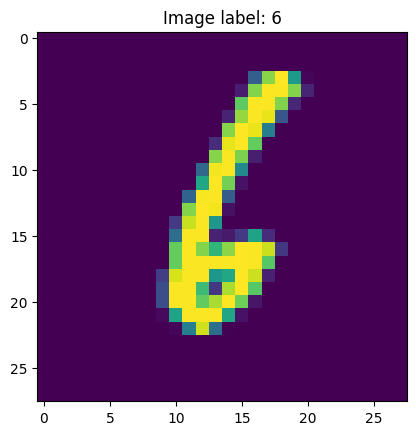

In [36]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    # num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    # num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель, представленную ниже. Пожалуйста, не создавайте чрезмерно сложную сеть — она не должна быть глубже четырёх слоёв (можно и меньше). Ваша основная задача — обучить модель и добиться как минимум 92% точности на тестовой выборке (hold-out выборке).

*Примечание: линейных слоёв и функций активации должно быть достаточно.*

__Обратите внимание, ваша модель должна быть представлена переменной `model`__

In [67]:
class ReLU(torch.nn.Module):
    def __init__(self):
        '''
        Слой ReLU поэлементно применяет rectified linear unit к своему входу
        '''
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Применяет ReLU ко входному тензору
        '''
        return torch.maximum(torch.tensor(0., device=x.device), x)

    def __repr__(self):
        '''
        Хорошей практикой является переопределение строкового представления для блоков
        Обычно, помимо названия класса также выводят гиперпараметры данного экземпляра класса
        '''
        return 'ReLU()'

In [68]:
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        '''
        Полносвязный слой — это слой выполняющий аффинное преобразование f(x) = x W + b
        '''
        super().__init__()

        # Создайте необходимые обучаемые параметры
        ### your code here
        self.weight = torch.nn.Parameter(torch.empty((in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.empty(out_features))

        # Выполните инициализацию весов
        self.reset_parameters()

    def reset_parameters(self):
        '''
        Инициализация весов полносвязного слоя из нормального распределения с
            нулевым средним и стандартным отклонением 0.01
        Вектор-смещение инициализируется нулями
        '''
        torch.nn.init.normal(self.weight, mean=0, std=0.01)
        torch.nn.init.zeros_(self.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Выполнение аффинного преобразования f(x) = x W + b

        :param torch.Tensor x: входная матрица размера [batch_size, in_features]
        :returns: матрица размера [batch_size, out_features]
        '''
        # [batch_size, in_features] * [in_features, out_features] = [batch_size, out_features]
        return x @ self.weight + self.bias

    def __repr__(self):
        '''
        Опциональный метод для красивого вывода
        '''
        return 'Linear({0:d}, {1:d})'.format(*self.weight.shape)

In [69]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def stable_log_softmax(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Численно стабильная реализация логсофтмакса.
        :param torch.Tensor x: Входной тензор размера [batch_size, n_classes]
        :returns: Тензор размера [batch_size, n_classes] после применения логсофтмакса
        '''
        c = torch.max(x, dim=1, keepdim=True).values
        log_sum_exp = torch.log(torch.sum(torch.exp(x - c), dim=1, keepdim=True))
        return (x - c) - log_sum_exp


    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Применение логсофтмакса к каждой строке, а затем выборка элементов в соответствии с метками истинного класса
        :param torch.Tensor x: Матрица логитов размера [batch_size, n_classes]
        :param torch.Tensor labels: Список меток истинного класса. Размер [batch_size]
        :returns: Кросс-энтропийная функция потерь
        """
        batch_size = x.size(0)

        log_softmax = self.stable_log_softmax(x)
        mask_labels = torch.zeros_like(log_softmax, dtype=torch.bool)
        mask_labels[torch.arange(batch_size), labels] = True

        nll = -log_softmax[mask_labels]
        return torch.mean(nll)

In [74]:
class DenseNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_size, n_classes, n_layers, activation=ReLU, dropout=0.0):
        '''
        :param int in_features: Число входных признаков
        :param int hidden_size: Размер скрытых слоёв
        :param int n_classes: Число выходов сети
        :param int n_layers: Число слоёв в сети
        :param torch.nn.Module activation: Класс функции активации
        '''
        super().__init__()
        layers = [torch.nn.Flatten()]  # <-- Обязательно первый слой

        if n_layers == 1:
            layers.append(torch.nn.Linear(in_features, n_classes))
        else:
            layers.append(torch.nn.Linear(in_features, hidden_size))
            layers.append(activation())
            layers.append(torch.nn.Dropout(dropout))
            for i in range(n_layers - 2):
                layers.append(torch.nn.Linear(hidden_size, hidden_size))
                layers.append(activation())
                layers.append(torch.nn.Dropout(dropout))
            layers.append(torch.nn.Linear(hidden_size, n_classes))

        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Прямой проход по сети
        :param torch.Tensor x: Входной тензор размера [batch_size, in_features]
        :returns: Матрица логитов размера [batch_size, n_classes]
        '''
        return self.layers(x)

In [75]:
import tqdm.notebook as tqdm

def training_loop(n_epochs, network, loss_fn, optimizer, train_data_loader, test_data_loader, device):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.nn.Optimizer optimizer: Оптимизатор (например, Adam)
    :param DataLoader train_data_loader: DataLoader для обучающей выборки
    :param DataLoader test_data_loader: DataLoader для тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True):
        # Переводим сеть в режим обучения
        network.train()

        # Обучение на одном эпохе
        epoch_train_loss = 0
        epoch_train_acc = 0
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.to(device)
            model.to(device)
            # Прямой проход
            logits = network(data)
            loss = loss_fn(logits, target)

            # Обратный проход
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Считаем метрики для батча
            epoch_train_loss += loss.item()
            pred = torch.argmax(logits, dim=1)
            acc = (pred == target).float().mean().item()
            epoch_train_acc += acc

        # Усредняем метрики по батчам
        avg_train_loss = epoch_train_loss / (batch_idx + 1)
        avg_train_acc = epoch_train_acc / (batch_idx + 1)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc * 100)

        # Переводим сеть в инференс режим
        network.eval()

        # При тестировании сети нет необходимости считать градиенты, поэтому можно отключить автоматическое дифференцирование
        #   для ускорения операций
        with torch.no_grad():
            epoch_test_loss = 0
            epoch_test_acc = 0
            for batch_idx, (data, target) in enumerate(test_data_loader):
                data, target = data.to(device), target.to(device)

                # Вычисление качества и функции потерь на тестовой выборке
                test_logits = network(data)
                test_loss = loss_fn(test_logits, target).item()
                epoch_test_loss += test_loss

                test_pred = torch.argmax(test_logits, dim=1)
                test_acc = (test_pred == target).float().mean().item()
                epoch_test_acc += test_acc

            # Усредняем метрики по батчам
            avg_test_loss = epoch_test_loss / (batch_idx + 1)
            avg_test_acc = epoch_test_acc / (batch_idx + 1)
            test_losses.append(avg_test_loss)
            test_accuracies.append(avg_test_acc * 100)

            if epoch % 20 == 0:
                print(
                    'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}'.format(
                        train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                    )
                )

    return train_losses, test_losses, train_accuracies, test_accuracies

In [76]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)

print(type(device), device)

<class 'torch.device'> cuda:0


In [77]:
# Creating model instance
model = DenseNetwork(
    in_features=784,
    hidden_size=512,
    n_classes=10,
    n_layers=4,
    activation=torch.nn.ReLU,
    dropout=0.2
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [78]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(init_weights)

DenseNetwork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=512, out_features=10, bias=True)
  )
)

Ниже доступны локальные тесты для проверки вашей модели:

In [82]:
model.to('cpu')

DenseNetwork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [83]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Обучите модель на обучающей выборке. Рекомендуем поэкспериментировать с различными оптимизаторами.


In [81]:
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=50,
    network=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
    device=device
)
# Немного переобучилась но перезагружать не буду

  0%|          | 0/50 [00:00<?, ?it/s]

Loss (Train/Test): 0.087/0.095. Accuracy, % (Train/Test): 97.42/97.37
Loss (Train/Test): 0.055/0.070. Accuracy, % (Train/Test): 98.35/98.17
Loss (Train/Test): 0.053/0.072. Accuracy, % (Train/Test): 98.41/98.06


Также помните, что вы всегда можете обратиться к отличной [документации](https://pytorch.org/docs/stable/index.html) и [учебным материалам](https://pytorch.org/tutorials/).

Оценим качество классификации:

In [84]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [85]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99417


In [86]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [87]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9808


Проверка, что пороги пройдены:

In [88]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model`, а файл `hw_mnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [91]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('/kaggle/input/mnist-dl/hw_mnist_data_dict.npy'), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('/kaggle/input/mnist-dl/hw_mnist_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_mnist_task_1.json`')
# __________end of block__________

File saved to `submission_dict_mnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_mnist_task_1.json` в задачу Warmup (hw_mnist)

На этом задание завершено. Поздравляем!